## Introduction

In this notebook we will train a baseline multi-output regression model in Keras on the images and the ancillary data (satellite data, soil data, climate data etc.) to predict the 6 plant properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

2024-05-14 23:27:45.765749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 23:27:45.765846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 23:27:45.897541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## global configuration
CFG = {
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 10,
    'n_conv_layers': 3,
    'n_tabular_blocks': 2,
    'tabular_layer_size': 128,
    'n_ff_blocks': 2,
    'ff_layer_size': 128
}

## Loading the data

In [3]:
path = Path('/kaggle/input/planttraits2024/')
imgs_train = path / 'train_images'
imgs_test = path / 'test_images'

train = pd.read_csv(path / 'train.csv')
train['img_path'] = train['id'].apply(lambda x: imgs_train / f'{x}.jpeg')

test = pd.read_csv(path / 'test.csv')
test['img_path'] = test['id'].apply(lambda x: imgs_test / f'{x}.jpeg')

In [4]:
# targets
target_desc = pd.read_table(path / 'target_name_meta.tsv', sep='\t')
targets = target_desc['trait_ID'].tolist()
for row in target_desc.iterrows():
    print(row[1].tolist())

['X4', 'Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume) ']
['X11', 'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA) ']
['X18', 'Plant height ']
['X26', 'Seed dry mass ']
['X50', 'Leaf nitrogen (N) content per leaf area ']
['X3112', 'Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded) ']


In [5]:
target_cols = [f'{col}_mean' for col in targets]
target_cols

['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

In [6]:
# remove sd columns
sd_cols = [f'{col}_sd' for col in targets]
train = train.drop(columns = sd_cols)

## Preprocessing

In [7]:
img_paths = train['img_path'].astype(str).values
tabular = train.drop(columns = ['id', 'img_path'] + target_cols).values
Y = train[target_cols]

In [8]:
# remove bad observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis= 1) & (Y > 0).all(axis=1)
img_paths = img_paths[retained_flag]
tabular = tabular[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 5691


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

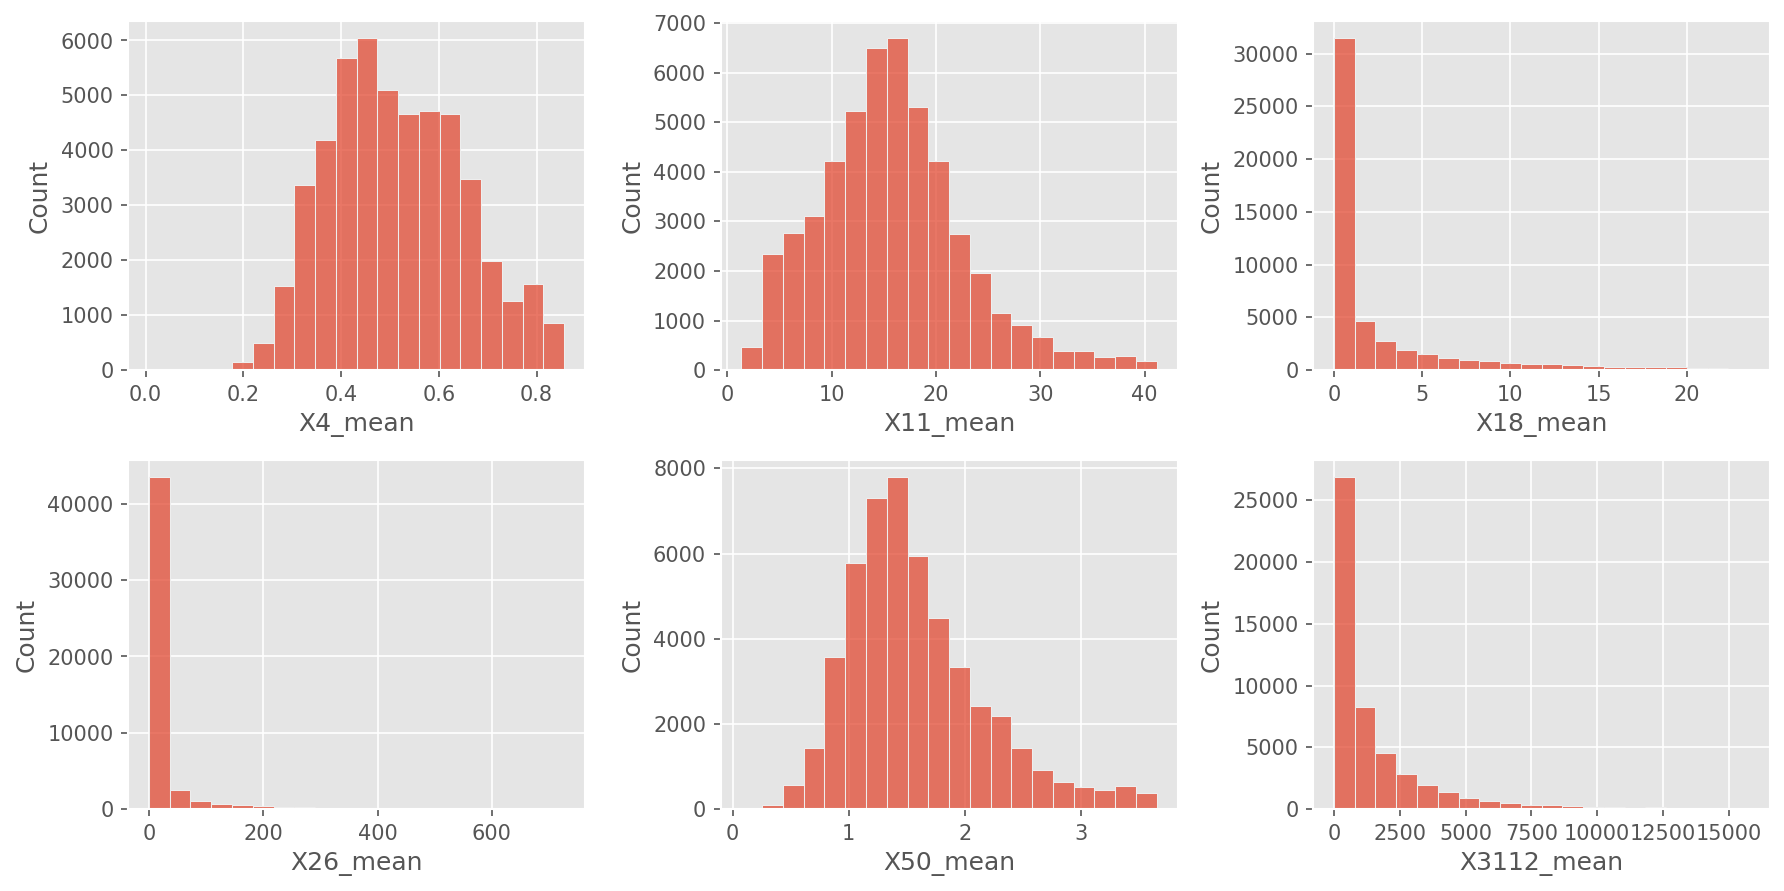

In [9]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()


In [10]:
# standardize response
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)

In [11]:
# normalize tabular inputs
tabular_input_sc = MinMaxScaler()
tabular_sc = tabular_input_sc.fit_transform(tabular)

## Image preprocessing functions

In [12]:
def process_image_from_file(file_path:str) -> tf.Tensor:
    # load the image
    img = tf.io.read_file(file_path)
    # decode the jpeg file 
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to 224 x 224 
    img = tf.image.resize(img, [224, 224])
    return img

# Define your dataset processing function
def process_path(file_path, tabular, targets):
    return (process_image_from_file(file_path), tabular), targets


## Create training and validation sets

In [13]:
paths_train, paths_val, tabular_train, tabular_val, Y_train, Y_val = train_test_split(
    img_paths, tabular_sc, Y_sc, random_state=2, test_size=0.2
)

train_ds = tf.data.Dataset.from_tensor_slices((paths_train, tabular_train.astype(np.float32), Y_train.astype(np.float32)))
val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32), Y_val.astype(np.float32)))


# preprocess and batch
train_ds = train_ds.map(process_path).batch(CFG['BATCH_SIZE'])
val_ds = val_ds.map(process_path).batch(CFG['BATCH_SIZE'])

## Model architecture

In [14]:
class ResNetBlock(keras.layers.Layer):
    def __init__(
        self,
        input_dim: int,
        normalization: str = 'batchnorm',
        hidden_factor: float = 2,
        hidden_dropout: float = 0.1,
        residual_dropout: float = 0.05
    ):
        super(ResNetBlock, self).__init__()

        self.norm = keras.layers.BatchNormalization() if normalization == 'batchnorm' \
            else  keras.layers.LayerNormalization()
        self.dense1 =  keras.layers.Dense(int(hidden_factor * input_dim))
        self.relu =  keras.layers.ReLU()
        self.dropout1 =  keras.layers.Dropout(hidden_dropout)
        self.dense2 =  keras.layers.Dense(input_dim)
        self.dropout2 =  keras.layers.Dropout(residual_dropout)

    def call(self, x):
        x_skip = x

        x = self.norm(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)

        return x + x_skip


In [15]:
keras.backend.clear_session()

############################## 
# IMG Processing
############################## 
img_input = keras.layers.Input(shape = (224, 224, 3), name="img_input")

img_backbone = keras.Sequential([
    keras.layers.Rescaling(scale=1./255),
    # augmentation layers
    keras.Sequential([
        keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
        keras.layers.RandomTranslation(
            height_factor=0.1, width_factor=0.1, interpolation='nearest'
        ),
        keras.layers.RandomZoom(height_factor=(0.05, 0.15)),
        keras.layers.RandomFlip(mode="horizontal_and_vertical")
    ], name='augmentation'),
], name='img_backbone')

# convolution blocks (default: 3) 
# each block consists of a convolution layer followed by a max pooling layer
for i in range(CFG.get('n_conv_layers',3)):
    img_backbone.add(keras.layers.Conv2D(
        CFG.get(f'n_filters_conv_{i+1}', 16*2**(i + 1)),kernel_size=(3,3)
    ))
    img_backbone.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# global average pooling
img_backbone.add(keras.layers.GlobalAveragePooling2D()) 

img_output = img_backbone(img_input)


############################## 
# Tabular Processing
##############################
tabular_input = keras.layers.Input(shape = (tabular_sc.shape[1],) , name="tabular_input")

backbone_blocks = [keras.layers.Dense(CFG['tabular_layer_size'])]
for i in range(CFG['n_tabular_blocks']):
    backbone_blocks.append(ResNetBlock(CFG['tabular_layer_size']))
    
tabular_backbone = keras.Sequential(backbone_blocks, name='tabular_backbone')
tabular_output = tabular_backbone(tabular_input)

##############################
# Concat and outputs
##############################
output = keras.layers.Concatenate()([img_output, tabular_output])
output = keras.layers.Dense(CFG['ff_layer_size'])(output)
for i in range(CFG['n_ff_blocks']):
    output = ResNetBlock(CFG['ff_layer_size'])(output)

output = keras.layers.Dense(6, name='output')(output)

model = keras.Model(inputs=[img_input, tabular_input], outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss= keras.losses.MeanAbsoluteError(),
    metrics=[keras.metrics.R2Score()]
)

print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 163)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_backbone        │ (None, 128)       │     93,248 │ img_input[0][0]   │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_backbone    │ (None, 128)       │    153,856 │ tabular_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ img_backbone[0][… │
│ (Concatenate)       │                   │            │ tabular_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net_block_2     │ (None, 128)       │     66,432 │ dense_5[0][0]     │
│ (ResNetBlock)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net_block_3     │ (None, 128)       │     66,432 │ res_net_block_2[… │
│ (ResNetBlock)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ res_net_block_3[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 413,638 (1.58 MB)

 Trainable params: 412,614 (1.57 MB)

 Non-trainable params: 1,024 (4.00 KB)

None


## Training

In [16]:
history = model.fit(train_ds, validation_data=val_ds, epochs=CFG['NUM_EPOCHS'])

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 115s 325ms/step - loss: 0.8557 - r2_score: -0.5380 - val_loss: 0.5947 - val_r2_score: 0.0895
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 152ms/step - loss: 0.6263 - r2_score: 0.0416 - val_loss: 0.5820 - val_r2_score: 0.1293
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - loss: 0.5981 - r2_score: 0.0805 - val_loss: 0.5914 - val_r2_score: 0.1176
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 152ms/step - loss: 0.5864 - r2_score: 0.0937 - val_loss: 0.5939 - val_r2_score: 0.1238
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - loss: 0.5792 - r2_score: 0.1034 - val_loss: 0.5723 - val_r2_score: 0.1401
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - loss: 0.5746 - r2_score: 0.1100 - val_loss: 0.5779 - val_r2_score: 0.1468
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - loss: 0.5705 - r2_score: 0.1179 - val_loss: 0.5743 - val_r2_score: 0.1414
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - loss: 0.5668 - r2_score:

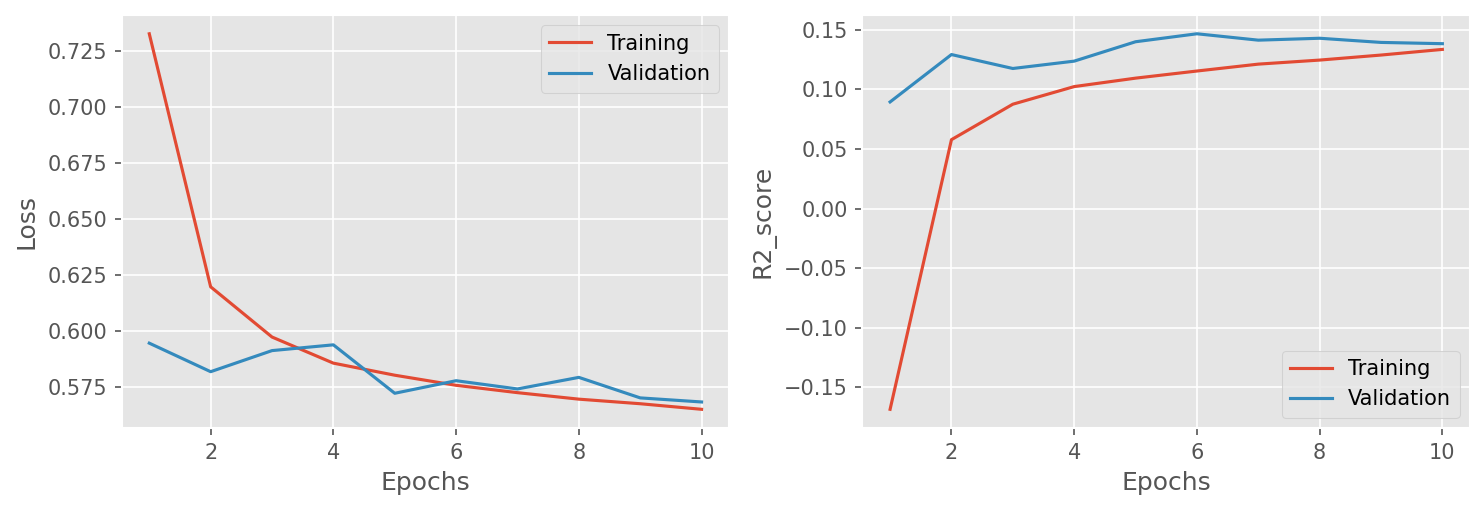

In [17]:
# plot training history
metrics = ['loss','r2_score']

fig,axs = plt.subplots(1,len(metrics),figsize=(5*len(metrics),3.5),dpi=150)

for i,metric in enumerate(metrics):
    
    _ = axs[i].plot(1 + np.arange(CFG['NUM_EPOCHS']), history.history[f'{metric}'],label='Training')
    _ = axs[i].plot(1 + np.arange(CFG['NUM_EPOCHS']), history.history[f'val_{metric}'],label='Validation')
    _ = axs[i].legend()
    _ = axs[i].set_ylabel(metric.capitalize())
    _ = axs[i].set_xlabel('Epochs')

fig.tight_layout()
fig.savefig('training_history.png',bbox_inches='tight')
fig.savefig('training_history.pdf',bbox_inches='tight')

In [18]:
# save weights
model.save_weights("model.weights.h5")

## Checking individual output R2

In [19]:
def process_paths_wo_targets(file_path, tabular):
    return ((process_image_from_file(file_path), tabular),)

# recreate the validation dataset without the targets
val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32)))
val_ds = val_ds.map(process_paths_wo_targets).batch(256)

y_val_pred = model.predict(val_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step


In [20]:
val_r2_scores = pd.Series(
    r2_score(Y_val, y_val_pred, multioutput='raw_values'),
    index=target_cols,
)
print(val_r2_scores)

X4_mean       0.147606
X11_mean      0.143076
X18_mean      0.215204
X26_mean      0.035377
X50_mean      0.070651
X3112_mean    0.218895
dtype: float64


## Test Predictions and Submission

In [21]:
paths_test = test['img_path'].astype(str).values
tabular_test = tabular_input_sc.transform(
    test.drop(columns = ['id', 'img_path']).values
).astype(np.float32)
test_ds = tf.data.Dataset.from_tensor_slices((paths_test, tabular_test))
test_ds = test_ds.map(process_paths_wo_targets).batch(256)
predictions = model.predict(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 579ms/step


In [22]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()


submission.to_csv('submission.csv', index=False)

In [23]:
submission.head()

,id,X4,X11,X18,X26,X50,X3112
0,201238668,0.534069,13.809235,0.758211,1.702579,1.298102,248.596542
1,202310319,0.456457,16.339737,0.619624,3.404492,1.487274,466.695679
2,202604412,0.476183,15.809433,0.555788,4.235526,1.489280,560.970581
3,201353439,0.437482,18.919586,0.446909,1.072803,1.224156,484.094849
4,195351745,0.495170,10.351980,-0.012874,-0.940289,1.573637,-124.857193
